# Brief description of the problem and data

Project Topic: The data for this project comes from a Kaggle competition. It consists of 10,000 tweets that have been hand-classified as being about a real disaster or not. The objective is to correctly classify the tweets that are about real disasters vs those that are not based on the F1 score (More info is highlighted below in the description). Essentially, this forms the basis towards how we fight against 'fake news'. 

Competition Description:
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).
In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. Submissions are evaluated using F1 between the predicted and expected answers.

Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

# Packages & Libraries

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import subprocess
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [5]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print(train_data.head(20))
print(train_data.info())

    id keyword location                                               text  \
0    1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1    4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2    5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3    6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4    7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5    8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6   10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7   13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8   14     NaN      NaN  There's an emergency evacuation happening now ...   
9   15     NaN      NaN  I'm afraid that the tornado is coming to our a...   
10  16     NaN      NaN        Three people died from the heat wave so far   
11  17     NaN      NaN  Haha South Tampa is getting flooded hah

The dataset consists 7613 entries with the following columns:

* id: a unique identifier for each tweet.
* keyword: a particular keyword from the tweet (may be blank).
* location: the location the tweet was sent from (may be blank).
* text: the text of the tweet.
* target: this is what we are trying to predict: if a tweet is about a real disaster (1), it's not about disaster (0).

Given that the 'keyword' and 'location' fields have missing values (NaNs), and the 'text' field is likely to contain various forms of noise (irrelevant information, typos, slang, etc.), our data cleaning process will involve:

* Handling missing values in 'keyword' and 'location'.
* Analyzing the distribution and relationships of the 'keywords', 'location', and 'text' with the target variable.
* Cleaning the 'text' of tweets to remove or correct noise.

In [6]:
missing_values = train_data.isnull().sum()
missing_values_percentage = (missing_values / len(train_data)) * 100

missing_data_summary = pd.DataFrame({"Missing Values": missing_values, 
                                     "Percentage": missing_values_percentage})
missing_data_summary

,Missing Values,Percentage
id,0,0.000000
keyword,61,0.801261
location,2533,33.272035
text,0,0.000000
target,0,0.000000


From the missing data table, we can see that:
* keyword: Approximately 0.8% of the entries are missing, which is relatively minor and could be manageable through imputation.
* location: About 33.27% of these entries are missing, which is significant. However, this seems plausible due to the nature of the data collected via the twitter platform online.

We will examine the frequency of real disaster across the overall data and across the missing data groups to see if they are missing randomly.

In [7]:
overall_proportion = train_data['target'].mean()

missing_keywords = train_data[train_data['keyword'].isna()]
proportion_missing_keywords = missing_keywords['target'].mean() if not missing_keywords.empty else 0

missing_location = train_data[train_data['location'].isna()]
proportion_missing_location = missing_location['target'].mean() if not missing_location.empty else 0

print("Overall proportion of disaster tweets:", overall_proportion)
print("Proportion of disaster tweets with missing keywords:", proportion_missing_keywords)
print("Proportion of disaster tweets with missing location:", proportion_missing_location)


Overall proportion of disaster tweets: 0.4296597924602653
Proportion of disaster tweets with missing keywords: 0.6885245901639344
Proportion of disaster tweets with missing location: 0.4243979470983024


These statistics suggest that the keyword may actually not be useful for disaster classification. In fact, if anything, we should be utilising the fact that they do not have a keyword.

On the other hand, the absence of location information doesn't show a marked deviation from the overall proportion of disaster tweets. This may imply that while location information can be helpful, its absence alone is not a significant factor in determining the nature of the tweet. 

At this point, we will make the decisions to not do any form of imputation because:
* location data has too much missing data and they do not pose any importance to prediction and
* also not to rely on keywords for disaster classification as it is likely not correlated to disaster.

Instead, we take a closer look at our target and actual text.

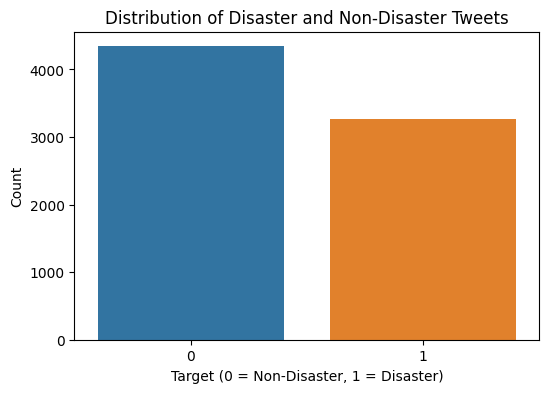

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Disaster and Non-Disaster Tweets')
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.show()

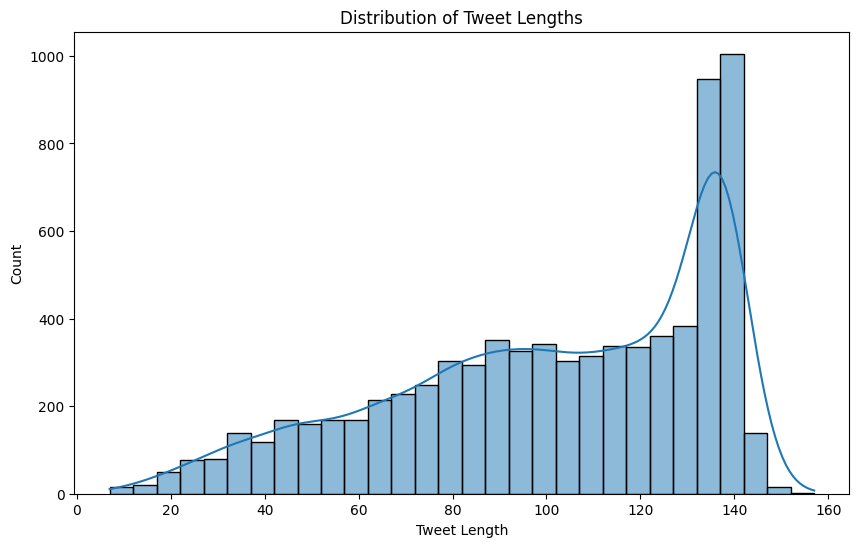

In [9]:
tweet_lengths = train_data['text'].str.len()
plt.figure(figsize=(10,6))
sns.histplot(tweet_lengths, bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.show()

The dataset contains a relatively balanced distribution of disaster and non-disaster tweets, which is good for model training. The lengths of tweets vary, with a significant number of tweets around 100-140 characters and reflects typical tweet length constraints. As highlighted earlier, there is also no missing values in text and target. Next, we will proceed with text-preprocessing for the text data as we saw that the data is very informal and contains lot of noises as seen in the train_data.head.

# Data Pre-processing

For the text, we will work on the following:

* Lowercase Conversion: Converts all text to lowercase for uniformity.
* Removing Emojis: Eliminates emojis from the text using a predefined list of emoji characters.
* Removing URLs and Mentions: Discards words containing "http", "https", and "@" to remove URLs and mentions.
* Removing Special Characters: Clears out non-word characters (punctuation, special symbols) from the text.
* Tokenization: Splits the text into individual words (tokens) using a regular expression that matches word characters.
* Removing Stopwords: Filters out common words (like "the", "is", etc.) that might not contribute significantly to the meaning.
* Lemmatization: Converts words to their base or dictionary form (e.g., "running" to "run"). This helps in reducing the complexity of the text data.
* Removing Digits: Removes words that are purely numeric.
* Removing Single Letters: Discards standalone single letters which typically do not contribute to the overall context.

In [10]:
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [11]:
emojis = ["\U0001F600", "\U0001F64F", "\U0001F300", "\U0001F5FF", "\U0001F680", "\U0001F6FF",
          "\U0001F1E0", "\U0001F1FF", "\U00002702", "\U000027B0", "\U000024C2", "\U0001F251"]

def preprocess_text(text):
    text = text.lower()

    for emoji in emojis:
        text = text.replace(emoji, "")

    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(text)

    stopWords = nltk.corpus.stopwords.words("english")
    tokens = [word for word in tokens if word not in stopWords]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]


    tokens = [word for word in tokens if not word.isdigit()]

    tokens = [word for word in tokens if len(word) > 1]

    return ' '.join(tokens)


train_data['preprocessed_text'] = train_data['text'].apply(preprocess_text)
train_data['preprocessed_text']

0                deed reason earthquake may allah forgive
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       people receive wildfire evacuation order calif...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    control wild fire california even northern par...
7610                           m194 utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest home razed northern california wildfire...
Name: preprocessed_text, Length: 7613, dtype: object

Next we will generate TF-IDF features with character-level N-grams, tokenization, and padding. 

* Nature: TF-IDF is a statistical measure used to evaluate the importance of a word to the article across our dataset. It's not a predictive model but a numerical statistic.

* Use Cases: It's commonly used in search engine scoring, text mining, and information retrieval. For example, it can help identify the most relevant documents from a search query or filter out common words that occur across all documents (like "is" or "and").

* Output: It results in a weight that highlights words with high relevance to a specific article. This is useful for scoring, ranking, and finding important words across articles.

* Methodology: It's calculated by multiplying two metrics: how many times a word appears in a article and the inverse article frequency of the word across a set of articles.

Understanding TF-IDF: https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/

TF-IDF is chosen because it highlights words that are crucial for the classification task, assigning higher weights to words that are frequent in individual tweets but not common across all tweets. This feature is particularly beneficial in emphasizing specific keywords that are indicative of disaster-related content. The technique effectively filters out "noise" by down-weighting common words that appear frequently across different tweets but don't contribute to distinguishing between disaster and non-disaster tweets. In the context of disaster tweets, certain terms or phrases are also particularly telling (e.g., 'earthquake', 'flood', 'evacuation'). TF-IDF helps in identifying and giving more weight to these distinctive terms, enhancing the model's ability to classify tweets accurately.

TF-IDF with Character-Level N-Grams:
* The TfidfVectorizer is set up to analyze the text at the character level.
* N-gram range is set from 3 to 7 characters.
* min_df and max_df parameters are used to filter out terms based on their frequency.

N-grams help in capturing the context in which words appear. This is crucial in understanding the meaning of tweets, where the sequence of words can significantly alter the meaning. Character-level n-grams, in particular, can capture the essence of word morphology and are less sensitive to spelling errors, which are common in social media text like tweets. In this case, we set it to 3-7 characters because it likely form some type of meaning across that range of words.

Tokenization:
* A Tokenizer is initialized and fitted on the preprocessed text.
* The preprocessed text is converted into sequences of integers, where each integer represents a unique token (word) in the text.

Padding:
* The sequences are padded to ensure they have the same length.
* Padding is applied at the end of the sequences (padding='post'), and the maximum length is determined by the longest sequence.

Lastly, neural networks, especially LSTM models, require inputs of the same length. Padding ensures that all sequences in the dataset are of uniform length. In this sense, it allows a fixed size for all text data, which is necessary for batch processing in neural networks. 

In [12]:
# TF-IDF with Character-Level N-Grams
vectorizer = TfidfVectorizer(
    min_df=2, max_df=0.2, 
    analyzer='char_wb', 
    ngram_range=(3,7)
)
X_tfidf = vectorizer.fit_transform(train_data['preprocessed_text']).toarray()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['preprocessed_text'])
train_sequences = tokenizer.texts_to_sequences(train_data['preprocessed_text'])

# Padding
max_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

# Basic LSTM

Now, we will build a basic LSTM model with the following architecture.

* Embedding Layer: This layer converts tokenized words into dense vectors of fixed size.
* LSTM Layer: The LSTM layer captures the dependencies in the sequence data, suitable for text. This includes a dropout of 0.2 and recurrent dropout of 0.2 to reduce overfitting.
* Dense Layer: A fully connected layer (RELU) to interpret the features extracted by the LSTM.
* Dropout: Used for regularization to prevent overfitting with a 0.5 value.
* Output Layer: Since this is a binary classification task, the output layer has one neuron with a sigmoid activation function.

In [13]:
vocabulary_size = len(tokenizer.word_index) + 1

model = Sequential()

model.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_length))

# LSTM Layer
model.add(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2))

# Fully Connected Layer
model.add(Dense(units=50, activation='relu'))

# Dropout for Regularization
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(units=1, activation='sigmoid'))

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           1400500   
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,433,301
Trainable params: 1,433,301
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
train_labels = train_data['target'].values
epochs = 5
batch_size = 64

model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/5
96/96 [==============================] - 9s 49ms/step - loss: 0.6122 - accuracy: 0.6552 - val_loss: 0.5219 - val_accuracy: 0.7387
Epoch 2/5
96/96 [==============================] - 4s 44ms/step - loss: 0.3556 - accuracy: 0.8598 - val_loss: 0.4810 - val_accuracy: 0.7919
Epoch 3/5
96/96 [==============================] - 4s 44ms/step - loss: 0.2243 - accuracy: 0.9245 - val_loss: 0.4838 - val_accuracy: 0.7761
Epoch 4/5
96/96 [==============================] - 4s 43ms/step - loss: 0.1552 - accuracy: 0.9501 - val_loss: 0.7402 - val_accuracy: 0.7492
Epoch 5/5
96/96 [==============================] - 4s 43ms/step - loss: 0.1232 - accuracy: 0.9616 - val_loss: 1.0136 - val_accuracy: 0.7472


Basic LSTM Results:

* Training Accuracy: Improved from 65.52% to 96.16% over 5 epochs.
* Training Loss: Decreased significantly, indicating effective learning.
* Validation Accuracy: Peaked at 79.19% in the second epoch but then declined.
* Validation Loss: Initially decreased, indicating good model fit, but increased in later epochs, suggesting overfitting.
* General Observation: The model showed signs of overfitting as evidenced by increasing validation loss and decreasing validation accuracy from the third epoch onwards.

This suggests that we can consider adjusting hyperparameters, adding regularization, or augmenting data to improve generalization even though there were some dropout mitigations that clearly wasnt working enough.

# Model 2 - Improving the LSTM

With the consideration of overfitting, the below adjustments are made to the basic LSTM model:

* Increased LSTM Units: The first LSTM layer's units have been increased to 64, enhancing the model's ability to capture more complex patterns in the data.
* Additional LSTM Layer: An extra LSTM layer with 32 units is added. This helps the model learn deeper sequential relationships in the text.
* L2 Regularization: L2 regularization is added to the LSTM and Dense layers. This regularization technique penalizes the weights' magnitude, encouraging simpler models that may generalize better.
* Optimized Learning Rate: The learning rate in the Adam optimizer is set to 0.001, which might be more suitable for achieving stable and effective training convergence.
* Adjusted Training Parameters: The model is trained with a smaller batch size (32).

In [17]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_length))

# Adding an extra LSTM layer with regularization
model2.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model2.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))

# Adding regularization
model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.5))

model2.add(Dense(1, activation='sigmoid'))

model2.summary()

# Compile with a different learning rate
optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train with a modified number of epochs and batch size
model2.fit(train_padded, train_labels, epochs=5, batch_size=32, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 100)           1400500   
                                                                 
 lstm_1 (LSTM)               (None, 23, 64)            42240     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,457,333
Trainable params: 1,457,333
No

Model 2 Results: 
* Training Accuracy: Started higher at 69.69% and improved to 96.37%, showing a consistently high learning rate across epochs.
*Training Loss: Started at a higher point (0.9858) but decreased more steadily, reflecting the impact of regularization.
*Validation Accuracy: Started at a higher point (77.94%) but showed a slight decrease over epochs, stabilizing around 74.66% - 76.69%.
*Validation Loss: Lower initial loss compared to the first model, but still showed an increasing trend, which might suggest mild overfitting.
*General Observation: The second model started with better initial performance and maintained a more consistent accuracy. The regularization techniques helped in reducing overfitting compared to the first model, but it still did not completely eliminate it.

# Model 3

Model 3 Architecture Changes:
* Bidirectional LSTM: Introduces a Bidirectional LSTM layer, enabling the model to process the text data in both forward and backward directions, capturing more contextual information.
* Increased Dropout Rates: The dropout rates in both the LSTM and Dense layers have been increased, providing stronger regularization to combat overfitting.
* Increased Recurrent Dropout: The recurrent dropout in the LSTM layer is also increased, further regularizing the internal state of the LSTM.
* Learning Rate Adjustment: The learning rate of the optimizer is reduced, allowing for more fine-grained adjustments in the model's learning process. 
* Early Stopping and Model Checkpointing: Incorporation of early stopping and model checkpointing to halt training when the validation loss stops improving and save the best version of the model, respectively.
* Adjusted Training Parameters: The model is trained with a even smaller batch size (16).

Understanding Bidirectional LSTM: https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/

In [26]:
# Model architecture
model3 = Sequential()
model3.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_length))
model3.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3)))
model3.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dropout(0.6))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

# Optimizer and learning rate
optimizer = Adam(learning_rate=0.0005)
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Model fitting
model3.fit(train_padded, train_labels, epochs=5, batch_size=16, validation_split=0.2, 
          callbacks=[early_stopping, model_checkpoint])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 23, 100)           1400500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 50)                5050      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1,466,001
Trainable params: 1,466,001
Non-trainable params: 0
____________________________________________

Model 3 Results: 
* Training Accuracy: Improved steadily from 66.44% to 93.92% over 4 epochs.
* Training Loss: Decreased from 0.8338 to 0.2066, showing effective learning.
* Validation Accuracy: Peaked at 78.87% in the first epoch and then showed a slight decrease, stabilizing around 76.95%.
* Validation Loss: Initially decreased, reaching its lowest at 0.4720 in the second epoch, but then increased in subsequent epochs, indicating overfitting.
* Early Stopping Activation: The training stopped after the 4th epoch, suggesting that early stopping was triggered due to a lack of improvement in the validation loss.

Model 3, with adjusted early stopping, shows an improvement in managing overfitting by halting training sooner. Although it didn't completely eliminate overfitting (as seen in the rising validation loss), the early stopping mechanism helped in capturing the model at a potentially more optimal point. This model seems to balance training performance and overfitting more effectively than Model 2. However, there might still be room for further optimization.

# Model 4

So far, we have been trying to improve the model via architectural improvement. However, it would seems that our embedding process could be enhanced too. Here, we seek to use GloVe (Global Vectors for Word Representation) embeddings for model 4.

How it works: 
GloVe embeddings are trained on a large corpus and capture semantic relationships between words. GloVe embeddings map words into a continuous vector space where distances and directions have semantic meanings. Words that are used in similar contexts have similar embeddings. This can be particularly useful for machine learning models that can operate on these dense vectors and leverage the semantic and syntactic relationships they encode. 

Why GloVe?
First, GloVe can capture synonyms, antonyms, and other semantic relations that TF-IDF cannot. TF-IDF, on the other hand, is a statistical measure that does not capture word semantics. It only reflects how important a word is to a document within a collection of documents. GloVe embeddings benefit from transfer learning since they are pre-trained on a large corpus (like Wikipedia or Common Crawl). This pre-training allows them to be useful across different domains and tasks, even with smaller datasets like our tweets here. More importantly, GloVe embeddings have a fixed, relatively low dimensionality, which can be beneficial for computational efficiency and avoiding overfitting in machine learning models. Lastly, dense word embeddings like GloVe tend to outperform sparse representations like TF-IDF because they can be fed into complex neural network architectures that are good at capturing contextual information, suggesting it could improve our LSTM modeling results.

Understanding GloVe:
https://jonathan-hui.medium.com/nlp-word-embedding-glove-5e7f523999f6

In [41]:
glove_tokenizer = Tokenizer(num_words=vocabulary_size)
glove_tokenizer.fit_on_texts(train_data['preprocessed_text'])
glove_sequences = glove_tokenizer.texts_to_sequences(train_data['preprocessed_text'])
train_padded = pad_sequences(glove_sequences, maxlen=max_length)

# Load GloVe embeddings
embedding_index = {}
glove_file_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare the embedding matrix
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, i in glove_tokenizer.word_index.items():
    if i >= vocabulary_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [42]:
# Using GloVe embeddings
model4 = Sequential()
model4.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_length, 
                     weights=[embedding_matrix], trainable=False))
model4.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3)))
model4.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
model4.add(Dropout(0.6))
model4.add(Dense(1, activation='sigmoid'))

model4.summary()

optimizer = Adam(learning_rate=0.0005)
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

model4.fit(train_padded, train_labels, epochs=5, batch_size=16, validation_split=0.2, 
           callbacks=[early_stopping, model_checkpoint])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 23, 100)           1400500   
                                                                 
 bidirectional_9 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_32 (Dense)            (None, 50)                5050      
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1,466,001
Trainable params: 65,501
Non-trainable params: 1,400,500
______________________________________

Model 4 Results:
* Training Accuracy: Starts at 73.66% and increases to 80.84% by the end of the 5th epoch.
* Validation Accuracy: Starts at 80.63% and ends at 81.68% by the 5th epoch.
* Training Loss: Starts at 0.8274 and decreases to 0.4545 by the end of the 5th epoch.
* Validation Loss: Starts at 0.5417 and decreases to 0.4356 by the 5th epoch.

While Model 3 shows higher training accuracy, Model 4 demonstrates better generalization to the validation set, as indicated by higher validation accuracy and decreasing validation loss. This suggests that Model 4, with the GloVe embeddings, is likely a better model for making predictions on new, unseen data. 

# Submission and Takeaways

With that, we submit the results for model 4 on the test data.

In [43]:
test_data['preprocessed_text'] = test_data['text'].apply(preprocess_text)
test_data['preprocessed_text']

0                             happened terrible car crash
1       heard earthquake different city stay safe ever...
2       forest fire spot pond goose fleeing across str...
3                    apocalypse lighting spokane wildfire
4                      typhoon soudelor kill china taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety fasten...
3259    storm ri worse last hurricane cityamp3others h...
3260                        green line derailment chicago
3261              meg issue hazardous weather outlook hwo
3262    cityofcalgary activated municipal emergency pl...
Name: preprocessed_text, Length: 3263, dtype: object

In [45]:
test_sequences = glove_tokenizer.texts_to_sequences(test_data['preprocessed_text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

y_pre = model4.predict(test_padded)
y_pre = np.round(y_pre).astype(int).reshape(-1)

sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

sub = pd.DataFrame({'id': sample_submission['id'], 'target': y_pre})

sub.to_csv('model4.csv', index=False)

102/102 [==============================] - 1s 8ms/step


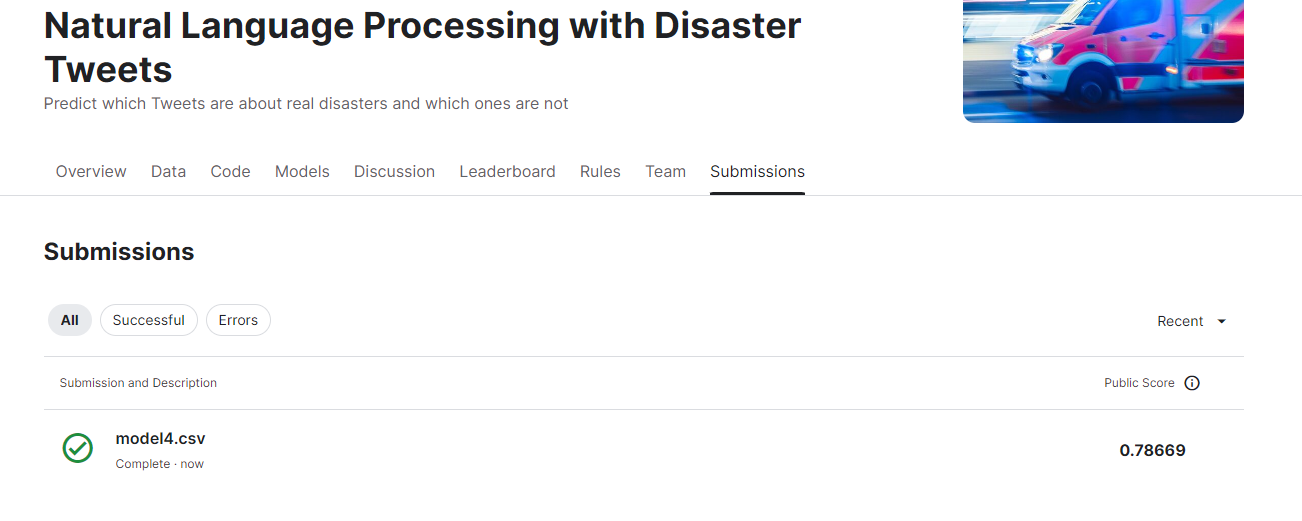

Throughout the iterative process of developing and refining four different LSTM models, several key learnings and takeaways have emerged:

* Model Complexity and Overfitting:
The initial models (Basic LSTM and Model 2) demonstrated a pattern of overfitting, where the training accuracy continued to increase while the validation accuracy peaked and then declined. This was also reflected in the increasing validation loss after a certain point. Throughout the whole process, it also seems that the effort to improve the models could result in too complex architecture that may cause even more overfitting in a cycle.

* Regularization Techniques:
To combat overfitting, various regularization techniques were employed, including dropout, recurrent dropout, and L2 regularization. These techniques help to prevent the model from becoming too complex by penalizing large weights and randomly dropping units during training, which encourages the model to learn more robust features. However, there seems to be a limit to how much we can do with the limited dataset as overdoing stuff seems to compromise the validation results.

* Bidirectional LSTM:
Model 3 introduced a Bidirectional LSTM layer, which processes the text data in both forward and backward directions. This allows the model to capture context from both sides of a sequence, often leading to better performance on sequence data tasks.

* GloVe Embeddings:
Model 4 incorporated pre-trained GloVe embeddings, which encode semantic information about words based on their co-occurrence in a large corpus. By leveraging transfer learning, GloVe embeddings provided a significant improvement in the model's ability to generalize, as evidenced by higher validation accuracy and a decreasing validation loss. Clearly, such steps to improving model accuracy could be seen as improvement outside the box of model architecture improvements.

* Hyperparameter Tuning:
Adjusting hyperparameters such as the learning rate, batch size, and the number of units in LSTM layers played a crucial role in the model's performance. A lower learning rate and smaller batch size often led to more stable and effective learning. On the other hand, the dataset is relatively low, allowing me to play with the tuning easily without compromising on load/speed.

* Performance Evaluation:
The final test results, with a score of 0.78668, indicate that Model 4 with GloVe embeddings indeed provides very good results for a LSTM model. It balanced the trade-off between fitting the training data and generalizing to new, unseen data, especially in such informal tweet context.

* Consistency in Preprocessing:
Lastly, something that cropped up for me was understanding that consistent preprocessing of datasets was very important when i was going for GloVe. The same tokenizer and sequence padding length used during training must be applied to the test data to ensure that the model can correctly interpret and classify the input. This was an issue although it did not feature in my final notebook results.

In conclusion, the iterative process of model development highlighted the importance of regularization, the benefits of using pre-trained embeddings, and the need for careful hyperparameter tuning. Model 4, which utilized GloVe embeddings, emerged as the best-performing model due to its superior generalization capabilities, ultimately leading to a successful submission with a competitive score on the test data. In the future, I would also be interested in looking at other embedding like word2vec and using advanced techniques like BERT for such classification problems.